In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader
from torch.autograd import grad

In [2]:
##### LOAD #########
# choose load file name
data_path="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L"
f1 = data_path+'/X_train_original_VAD30_wav2vec2_xlsr_small_last16_cms.npy'
f2 = data_path+'/y1_train_original_VAD30_wav2vec2_xlsr_small_last16_cms.npy'
#f3 = 'X_train_AUG-10-15-25-35-40-45-50_IIITH_23L_MFCC_cms_new.npy'
#f4 = 'y_train_AUG-10-15-25-35-40-45-50_IIITH_23L_MFCC_cms_new.npy'
f5 = data_path+'/X_test_original_VAD30_wav2vec2_xlsr_small_last16_cms.npy'
f6 = data_path+'/y1_test_original_VAD30_wav2vec2_xlsr_small_last16_cms.npy'

X_train = np.load(f1)
#X_aug=np.load(f3,allow_pickle=True)
X_valid = np.load(f5)
y_train = np.load(f2,allow_pickle=True)
#y_aug=np.load(f4,allow_pickle=True)
y_valid = np.load(f6,allow_pickle=True)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
#print(f'X_aug:{X_aug.shape}, y_aug:{y_aug.shape}')
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')

X_train:(24540, 300, 1024), y_train:(24540,)
X_valid:(6818, 300, 1024), y_valid:(6818,)


In [3]:
print(np.unique(y_train,return_counts=True))
#print(np.unique(y_aug,return_counts=True))
print(np.unique(y_valid,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int16), array([1159, 1220, 1096, 1057, 1183,  424,  211, 1205, 1056, 1294,  940,
       1218, 1310, 1092, 1270, 1355, 1277,  845, 1367,  432, 1351, 1259,
        919]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int16), array([382, 235, 255, 493, 295, 136,  38, 325, 377, 442, 126, 359, 380,
       188, 428, 414, 375, 213, 267,  65, 425, 476, 124]))


In [6]:
#ecapa noramal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
import sys
sys.path.insert(0, "/home/bhagya/asv-subtools-master/pytorch/")
import libs.support.utils as utils
from libs.nnet import *

# refs:
# 1.  ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification
#           https://arxiv.org/abs/2005.07143
# 2.  Unofficial implementation of the ECAPA-TDNN model.
#       https://github.com/lawlict/ECAPA-TDNN




''' Res2Conv1d + BatchNorm1d + ReLU
'''
class Res2Conv1dReluBn(nn.Module):
    '''
    inputs_dim == out_channels == channels
    '''
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out



''' Conv1d + BatchNorm1d + ReLU
'''
class Conv1dReluBn(nn.Module):
    def __init__(self, inputs_dim, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(inputs_dim, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))



''' The SE connection of 1D case.
'''
class SE_Connect(nn.Module):
    def __init__(self, channels, s=4):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channesl, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out

#Another implementation of SE_Connect
# class SE_Connect(nn.Module):
#     def __init__(self, channels, bottleneck=128):
#         super(SE_Connect, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool1d(1),
#             nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
#             nn.ReLU(),
#             # nn.BatchNorm1d(bottleneck),
#             nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
#             nn.Sigmoid(),
#             )

#     def forward(self, input):
#         x = self.se(input)
#         return input * x


''' SE-Res2Block.
    Note: residual connection is implemented in the ECAPA_TDNN model, not here.
'''
def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )



''' Attentive weighted mean and standard deviation pooling.
'''
class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1) # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1) # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)



''' Implementation of
    "ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification".

    Note that we DON'T concatenate the last frame-wise layer with non-weighted mean and standard deviation,
    because it brings little improvment but significantly increases model parameters.
    As a result, this implementation basically equals the A.2 of Table 2 in the paper.
'''
class ECAPA_TDNN(TopVirtualNnet):
    def init(self, inputs_dim, num_targets, channels=512, embd_dim=192,
             aug_dropout=0.5, tail_dropout=0.5, training=True,
             extracted_embedding="near", mixup=False, mixup_alpha=1.0,
             pooling="ecpa-attentive", pooling_params={}, fc1=False, fc1_params={}, fc2_params={},
             margin_loss= True, margin_loss_params={}, use_step=False, step_params={}, transfer_from="softmax_loss" ):


        default_pooling_params = {
            "num_head":1,
            "hidden_size":64,
            "share":True,
            "affine_layers":1,
            "context":[0],
            "stddev":True,
            "temperature":False,
            "fixed":True
        }

        default_fc_params = {
            "nonlinearity":'relu', "nonlinearity_params":{"inplace":True},
            "bn-relu":False,
            "bn":True,
            "bn_params":{"momentum":0.5, "affine":True, "track_running_stats":True}
            }


        default_margin_loss_params = {
            "method":"am", "m":0.2,
            "feature_normalize":True, "s":30,
            "double":False,
            "mhe_loss":False, "mhe_w":0.01,
            "inter_loss":0.,
            "ring_loss":0.,
            "curricular":False}

        default_step_params = {
            "T":None,
            "m":False, "lambda_0":0, "lambda_b":1000, "alpha":5, "gamma":1e-4,
            "s":False, "s_tuple":(30, 12), "s_list":None,
            "t":False, "t_tuple":(0.5, 1.2),
            "p":False, "p_tuple":(0.5, 0.1)
        }

        self.use_step = use_step
        self.step_params = step_params
        self.extracted_embedding = extracted_embedding

        pooling_params = utils.assign_params_dict(default_pooling_params, pooling_params)
        fc1_params = utils.assign_params_dict(default_fc_params, fc1_params)
        fc2_params = utils.assign_params_dict(default_fc_params, fc2_params)
        margin_loss_params = utils.assign_params_dict(default_margin_loss_params, margin_loss_params)
        step_params = utils.assign_params_dict(default_step_params, step_params)


        #self.mixup = Mixup(alpha=mixup_alpha) if mixup else None
        #self.pcmvn = AdaptivePCMN(20)
        self.layer1 = Conv1dReluBn(inputs_dim, channels, kernel_size=5, padding=2)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)
        cat_channels = channels * 3
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.bn_conv = nn.BatchNorm1d(cat_channels)

        # Pooling
        stddev = pooling_params.pop("stddev")
        if pooling == "attentive":
            self.stats = AttentiveStatisticsPooling(cat_channels, hidden_size=pooling_params["hidden_size"],context=pooling_params["context"], stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "ecpa-attentive":
            self.stats = AttentiveStatsPool(cat_channels,128)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-head":
            self.stats = MultiHeadAttentionPooling(cat_channels, stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "global-multi":
            self.stats = GlobalMultiHeadAttentionPooling(cat_channels,stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-resolution":
            self.stats = MultiResolutionMultiHeadAttentionPooling(cat_channels, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None

        else:
            self.stats = StatisticsPooling(cat_channels, stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None

        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

        if fc1:
            fc2_in_dim = embd_dim
        else:
            fc2_in_dim = cat_channels * 2
        self.fc2 = ReluBatchNormTdnnLayer(fc2_in_dim, embd_dim, **fc2_params)
        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

         # Loss
        # Do not need when extracting embedding.
        if training :
            if margin_loss:
                self.loss = MarginSoftmaxLoss(embd_dim, num_targets, **margin_loss_params)
            else:
                self.loss = SoftmaxLoss(embd_dim, num_targets)
                # self.loss = AngleLoss(embd_dim,num_targets)
            self.wrapper_loss = MixupLoss(self.loss, self.mixup) if mixup else None
            # An example to using transform-learning without initializing loss.affine parameters
            self.transform_keys = ["layer2","layer3","layer4","conv","stats","fc1","fc2"]

            if margin_loss and transfer_from == "softmax_loss":
                # For softmax_loss to am_softmax_loss
                self.rename_transform_keys = {"loss.affine.weight":"loss.weight"}

    @utils.for_device_free
    def forward(self, x):
        #x = self.mixup(x)
        #x = self.pcmvn(x)
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        x = self.auto(self.fc1, x)
        x = self.fc2(x)
        x = self.auto(self.tail_dropout, x)
        return x

    @utils.for_device_free
    def get_loss(self, inputs, targets):
        """Should call get_loss() after forward() with using Xvector model function.
        e.g.:
            m=Xvector(20,10)
            loss=m.get_loss(m(inputs),targets)

        model.get_loss [custom] -> loss.forward [custom]
          |
          v
        model.get_accuracy [custom] -> loss.get_accuracy [custom] -> loss.compute_accuracy [static] -> loss.predict [static]
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss(inputs, targets)
        else:
            return self.loss(inputs, targets)

    @utils.for_device_free
    def get_accuracy(self, targets):
        """Should call get_accuracy() after get_loss().
        @return: return accuracy
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss.get_accuracy(targets)
        else:
            return self.loss.get_accuracy(targets)

    @for_extract_embedding(maxChunk=10000, isMatrix=True)
    def extract_embedding(self, inputs):
        out1 = self.layer1(inputs)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        if self.extracted_embedding == "far":
            assert self.fc1 is not None
            xvector = self.fc1.affine(x)
        elif self.extracted_embedding == "near_affine":
            x = self.auto(self.fc1, x)
            xvector = self.fc2.affine(x)
        elif self.extracted_embedding == "near":
            x = self.auto(self.fc1, x)
            xvector = self.fc2(x)
        else:
            raise TypeError("Expected far or near position, but got {}".format(self.extracted_embedding))
        return xvector

    def get_warmR_T(T_0, T_mult, epoch):
        n = int(math.log(max(0.05, (epoch / T_0 * (T_mult - 1) + 1)), T_mult))
        T_cur = epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
        T_i = T_0 * T_mult ** (n)
        return T_cur, T_i

    def compute_decay_value(self, start, end, T_cur, T_i):
        # Linear decay in every cycle time.
        return start - (start - end)/(T_i-1) * (T_cur%T_i)

    def step(self, epoch, this_iter, epoch_batchs):
        # Heated up for t and s.
        # Decay for margin and dropout p.
        if self.use_step:
            if self.step_params["m"]:
                current_postion = epoch*epoch_batchs + this_iter
                lambda_factor = max(self.step_params["lambda_0"],
                                 self.step_params["lambda_b"]*(1+self.step_params["gamma"]*current_postion)**(-self.step_params["alpha"]))
                self.loss.step(lambda_factor)

            if self.step_params["T"] is not None and (self.step_params["t"] or self.step_params["p"]):
                T_cur, T_i = get_warmR_T(*self.step_params["T"], epoch)
                T_cur = T_cur*epoch_batchs + this_iter
                T_i = T_i * epoch_batchs

            if self.step_params["t"]:
                self.loss.t = self.compute_decay_value(*self.step_params["t_tuple"], T_cur, T_i)

            if self.step_params["p"]:
                self.aug_dropout.p = self.compute_decay_value(*self.step_params["p_tuple"], T_cur, T_i)

            if self.step_params["s"]:
                self.loss.s = self.step_params["s_tuple"][self.step_params["s_list"][epoch]]


if __name__ == '__main__':
    # Input size: batch_size * seq_len * feat_dim
    x = torch.zeros(2, 20, 300)
    model = ECAPA_TDNN(inputs_dim=20,num_targets=5, channels=512, embd_dim=192)
    out = model(x)
    print(model)
    print(out.shape)    # should be [2, 192]

ECAPA_TDNN(
  (layer1): Conv1dReluBn(
    (conv): Conv1d(20, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0-6): 7 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (bns): ModuleList(
        (0-6): 7 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): SE_Connect(
      (linear1): Linear(in_features=512

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [7]:
def xv_data_manage(X_test):
    aa=X_test.transpose((0,2,1))
    print(X_test.shape, '-->', aa.shape)
    return aa

In [8]:
X_train=xv_data_manage(X_train)
X_valid=xv_data_manage(X_valid)

(24540, 300, 1024) --> (24540, 1024, 300)
(6818, 300, 1024) --> (6818, 1024, 300)


In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#deice=torch.device("cpu")
model = ECAPA_TDNN(1024,23).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=0.0000001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

In [14]:
trainloader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=256,drop_last=False)
testloader1 = torch.utils.data.DataLoader(list(zip(X_valid,y_valid)), shuffle=True, batch_size=64,drop_last=False)
#testloader2 = torch.utils.data.DataLoader(list(zip(X_test,y_test)), shuffle=True, batch_size=32,drop_last=False)
print(len(trainloader))
print(len(testloader1))
#print(len(testloader2))
#print(len(testloader3))

96
107


In [15]:
np.unique(y_valid,return_counts =True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22], dtype=int16),
 array([382, 235, 255, 493, 295, 136,  38, 325, 377, 442, 126, 359, 380,
        188, 428, 414, 375, 213, 267,  65, 425, 476, 124]))

Epoch: 0, Batch: 0, Loss: 10.92640495300293, Accuracy:5.46875%
Epoch: 0, Batch: 50, Loss: 2.1390695571899414, Accuracy:88.671875%
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 0.5734330415725708, Accuracy:90.625%
#####TEST--in-domain:::::Epoch: 0, Batch: 50, Loss: 0.5417576432228088, Accuracy:89.0625%
#####TEST--in-domain:::::Epoch: 0, Batch: 100, Loss: 0.9556164741516113, Accuracy:85.9375%


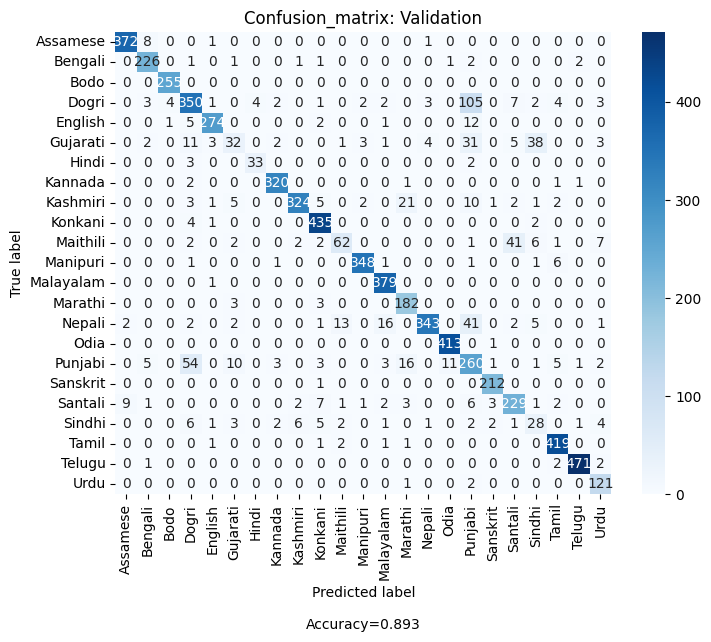

:::::Total vlidation loss 0.5555292763442636, Training accuracy 0.7963732681336594, Validation accuracy 0.892930478146084 after 0 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 1, Batch: 0, Loss: 0.9408645629882812, Accuracy:94.53125%
Epoch: 1, Batch: 50, Loss: 0.6563552021980286, Accuracy:97.265625%
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 0.5675605535507202, Accuracy:90.625%
#####TEST--in-domain:::::Epoch: 1, Batch: 50, Loss: 1.140731930732727, Accuracy:81.25%
#####TEST--in-domain:::::Epoch: 1, Batch: 100, Loss: 0.4999373257160187, Accuracy:89.0625%


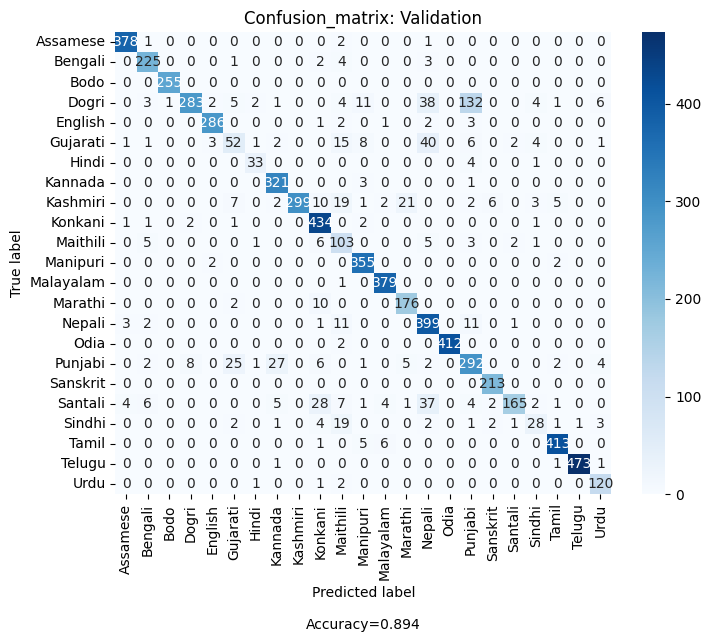

:::::Total vlidation loss 0.7697554927005946, Training accuracy 0.9696006519967401, Validation accuracy 0.8938105016133764 after 1 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 2, Batch: 0, Loss: 0.40801772475242615, Accuracy:98.828125%
Epoch: 2, Batch: 50, Loss: 0.4017106294631958, Accuracy:98.4375%
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 1.1731107234954834, Accuracy:84.375%
#####TEST--in-domain:::::Epoch: 2, Batch: 50, Loss: 0.6900514960289001, Accuracy:85.9375%
#####TEST--in-domain:::::Epoch: 2, Batch: 100, Loss: 0.6322233080863953, Accuracy:90.625%


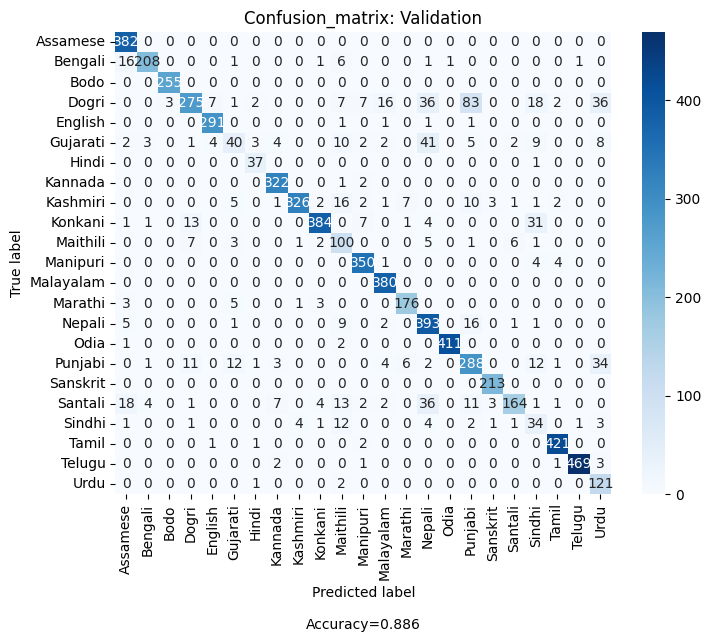

:::::Total vlidation loss 0.7343963075464017, Training accuracy 0.9902607986960065, Validation accuracy 0.8858902904077443 after 2 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 3, Batch: 0, Loss: 0.17825491726398468, Accuracy:100.0%
Epoch: 3, Batch: 50, Loss: 0.07678912580013275, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 0.36885419487953186, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 3, Batch: 50, Loss: 0.6361675262451172, Accuracy:90.625%
#####TEST--in-domain:::::Epoch: 3, Batch: 100, Loss: 1.1693110466003418, Accuracy:84.375%


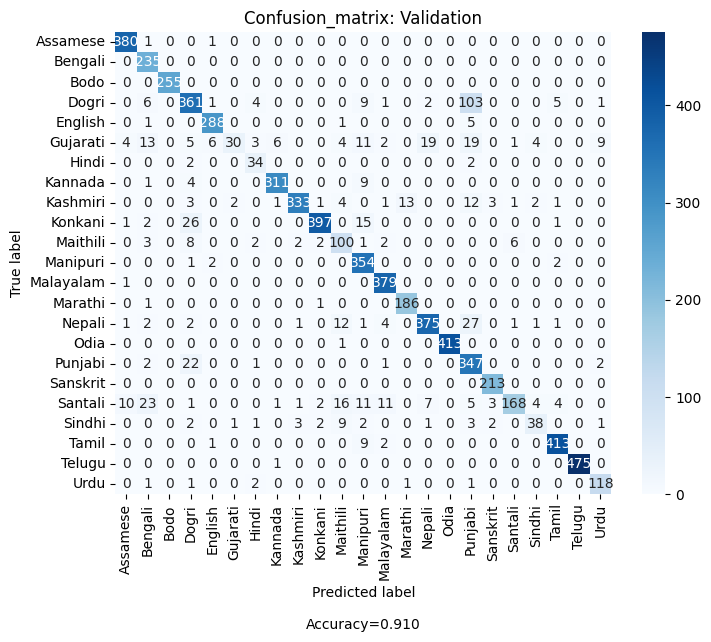

:::::Total vlidation loss 0.5945507560934976, Training accuracy 0.9971475142624286, Validation accuracy 0.9097975946025227 after 3 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 4, Batch: 0, Loss: 0.08021461218595505, Accuracy:99.609375%
Epoch: 4, Batch: 50, Loss: 0.018546808511018753, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 0.28272584080696106, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 4, Batch: 50, Loss: 0.6179360747337341, Accuracy:90.625%
#####TEST--in-domain:::::Epoch: 4, Batch: 100, Loss: 0.7626430988311768, Accuracy:92.1875%


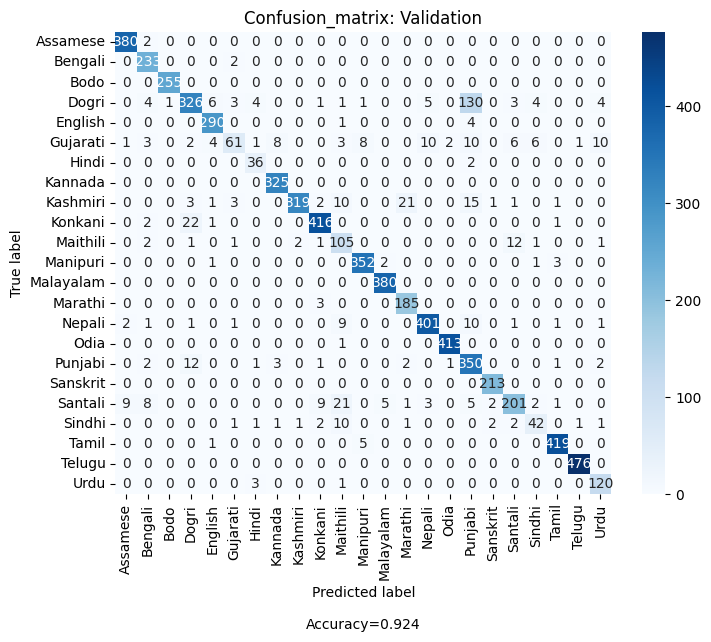

:::::Total vlidation loss 0.5745174349922139, Training accuracy 0.9995517522412388, Validation accuracy 0.92373129950132 after 4 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 5, Batch: 0, Loss: 0.034009356051683426, Accuracy:100.0%
Epoch: 5, Batch: 50, Loss: 0.009330985136330128, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 0.1506061553955078, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 5, Batch: 50, Loss: 1.0651533603668213, Accuracy:84.375%
#####TEST--in-domain:::::Epoch: 5, Batch: 100, Loss: 0.2524731755256653, Accuracy:96.875%


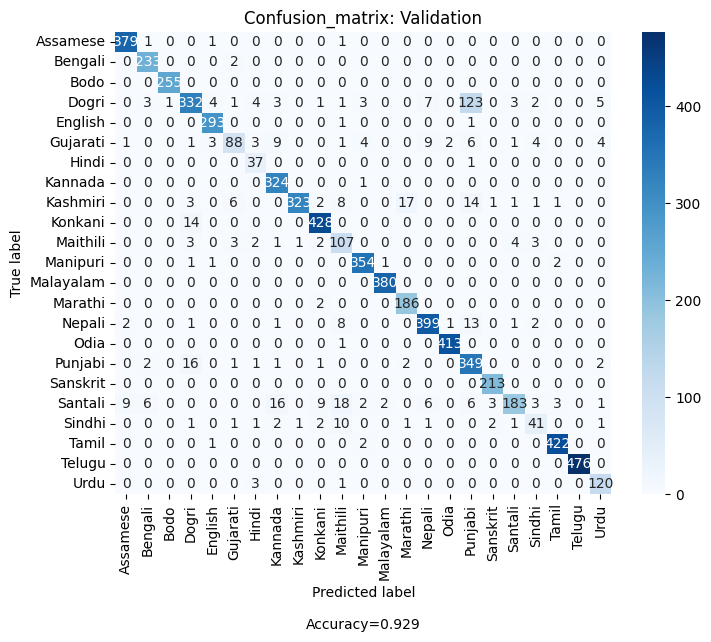

:::::Total vlidation loss 0.5274865887885061, Training accuracy 0.999959250203749, Validation accuracy 0.9291581108829569 after 5 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 6, Batch: 0, Loss: 0.011601988226175308, Accuracy:100.0%
Epoch: 6, Batch: 50, Loss: 0.014409628696739674, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 0.19167397916316986, Accuracy:95.3125%
#####TEST--in-domain:::::Epoch: 6, Batch: 50, Loss: 0.17439374327659607, Accuracy:95.3125%
#####TEST--in-domain:::::Epoch: 6, Batch: 100, Loss: 0.8321019411087036, Accuracy:90.625%


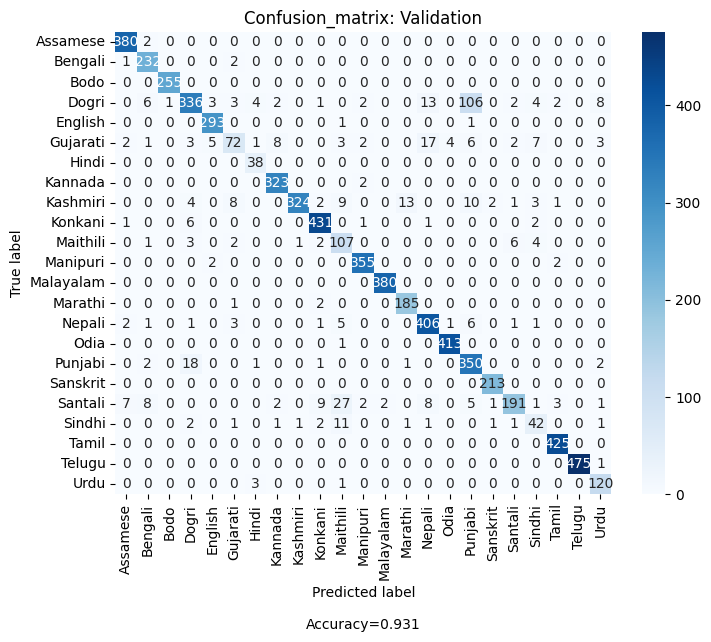

:::::Total vlidation loss 0.5292210097067824, Training accuracy 1.0, Validation accuracy 0.9307714872396597 after 6 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 7, Batch: 0, Loss: 0.0036181812174618244, Accuracy:100.0%
Epoch: 7, Batch: 50, Loss: 0.018055371940135956, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 0.12264697253704071, Accuracy:95.3125%
#####TEST--in-domain:::::Epoch: 7, Batch: 50, Loss: 0.4525262713432312, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 7, Batch: 100, Loss: 1.2613409757614136, Accuracy:89.0625%


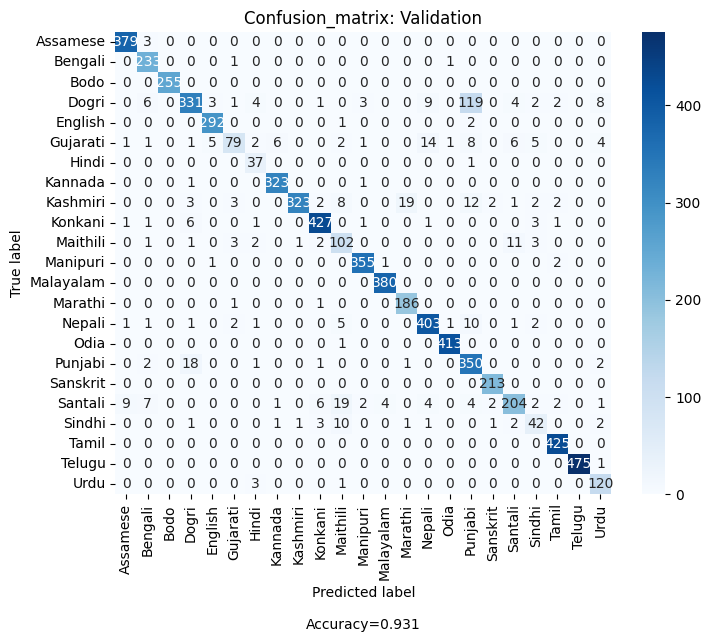

:::::Total vlidation loss 0.5135111480376848, Training accuracy 1.0, Validation accuracy 0.9309181578175418 after 7 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 8, Batch: 0, Loss: 0.0028195728082209826, Accuracy:100.0%
Epoch: 8, Batch: 50, Loss: 0.006431525107473135, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 0.14416129887104034, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 8, Batch: 50, Loss: 0.27298831939697266, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 8, Batch: 100, Loss: 0.3450324237346649, Accuracy:96.875%


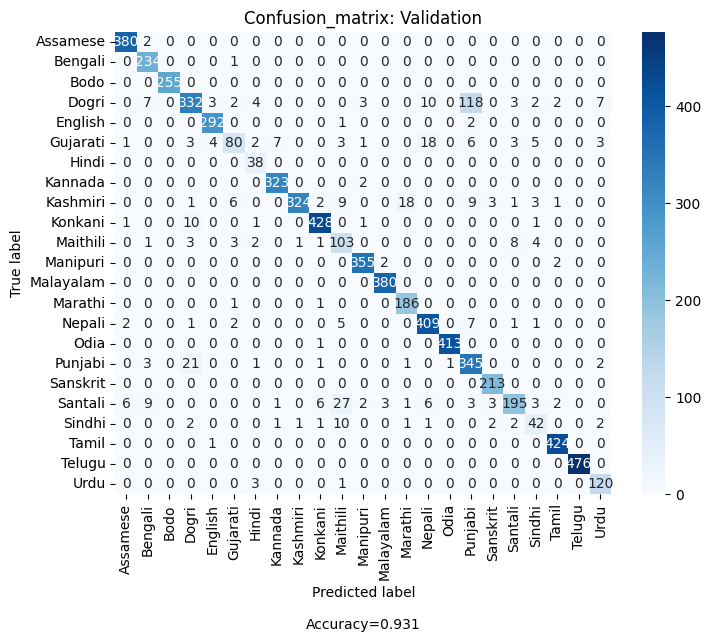

:::::Total vlidation loss 0.4946402496283996, Training accuracy 1.0, Validation accuracy 0.9309181578175418 after 8 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 9, Batch: 0, Loss: 0.008832477033138275, Accuracy:100.0%
Epoch: 9, Batch: 50, Loss: 0.002756571164354682, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 0.22249490022659302, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 9, Batch: 50, Loss: 1.1200628280639648, Accuracy:89.0625%
#####TEST--in-domain:::::Epoch: 9, Batch: 100, Loss: 0.7813987731933594, Accuracy:90.625%


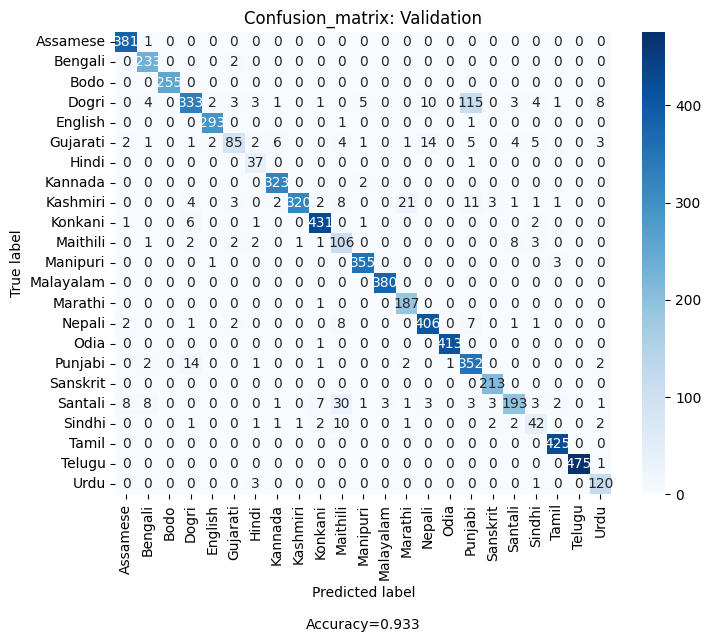

:::::Total vlidation loss 0.49486129753134933, Training accuracy 1.0, Validation accuracy 0.9325315341742446 after 9 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 10, Batch: 0, Loss: 0.004623733926564455, Accuracy:100.0%
Epoch: 10, Batch: 50, Loss: 0.007270880043506622, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 0.33495843410491943, Accuracy:92.1875%
#####TEST--in-domain:::::Epoch: 10, Batch: 50, Loss: 0.6346540451049805, Accuracy:92.1875%
#####TEST--in-domain:::::Epoch: 10, Batch: 100, Loss: 1.342605471611023, Accuracy:89.0625%


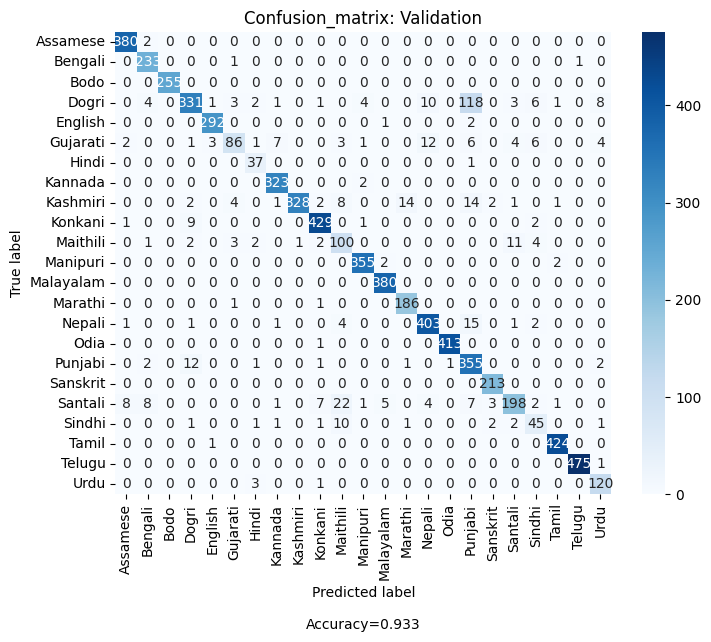

:::::Total vlidation loss 0.48684136929163474, Training accuracy 1.0, Validation accuracy 0.9329715459078909 after 10 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 11, Batch: 0, Loss: 0.0034564814995974302, Accuracy:100.0%
Epoch: 11, Batch: 50, Loss: 0.006122977007180452, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 0.5378050804138184, Accuracy:92.1875%
#####TEST--in-domain:::::Epoch: 11, Batch: 50, Loss: 1.1581907272338867, Accuracy:89.0625%
#####TEST--in-domain:::::Epoch: 11, Batch: 100, Loss: 0.30323147773742676, Accuracy:93.75%


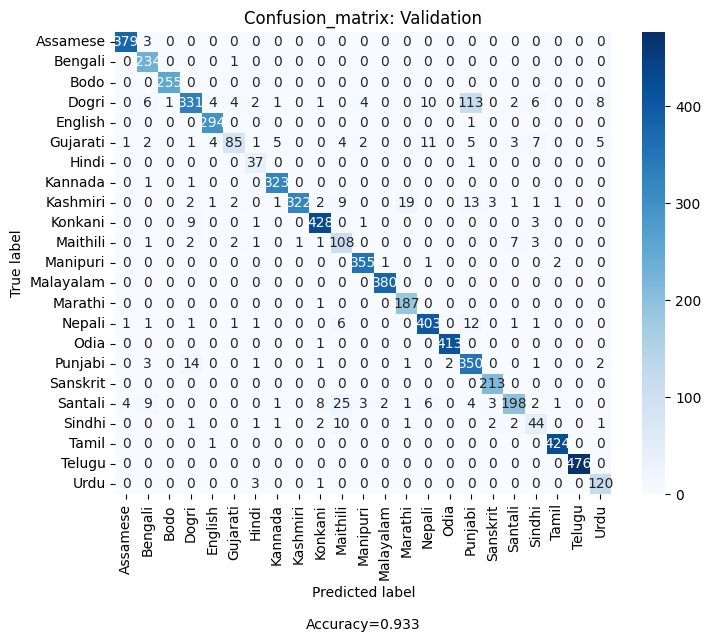

:::::Total vlidation loss 0.47152355969578863, Training accuracy 1.0, Validation accuracy 0.9326782047521267 after 11 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 12, Batch: 0, Loss: 0.0031369426287710667, Accuracy:100.0%
Epoch: 12, Batch: 50, Loss: 0.001554731628857553, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 0.34802910685539246, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 12, Batch: 50, Loss: 0.2919216752052307, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 12, Batch: 100, Loss: 0.2416752278804779, Accuracy:98.4375%


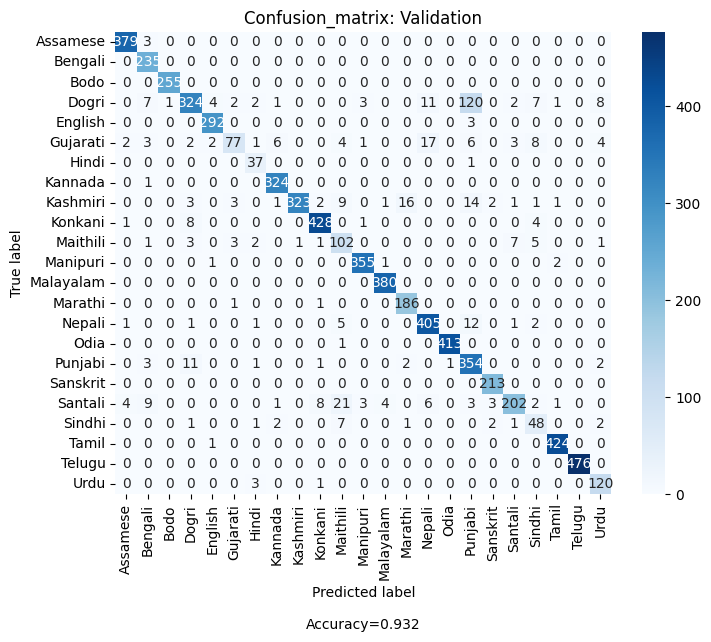

:::::Total vlidation loss 0.505451827075019, Training accuracy 1.0, Validation accuracy 0.9316515107069522 after 12 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 13, Batch: 0, Loss: 0.003270257730036974, Accuracy:100.0%
Epoch: 13, Batch: 50, Loss: 0.0015463390154764056, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 0.33414405584335327, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 13, Batch: 50, Loss: 0.668007493019104, Accuracy:89.0625%
#####TEST--in-domain:::::Epoch: 13, Batch: 100, Loss: 0.5767227411270142, Accuracy:93.75%


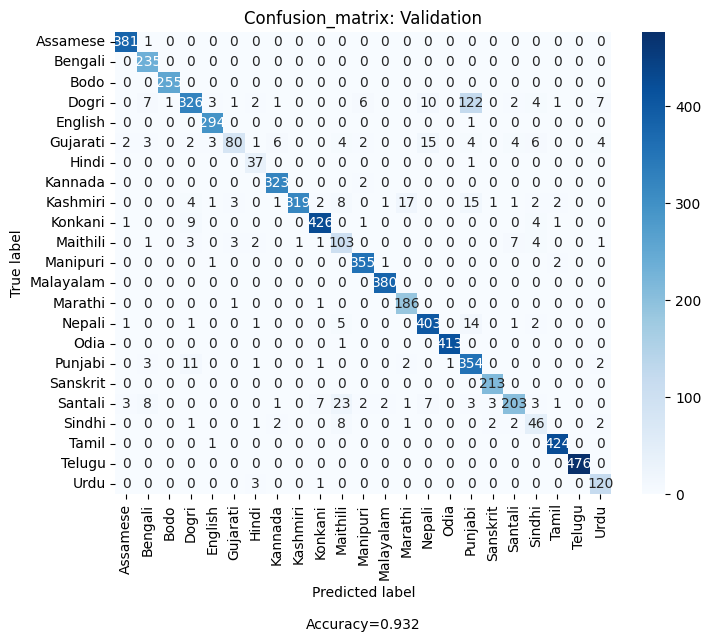

:::::Total vlidation loss 0.5028512392576053, Training accuracy 1.0, Validation accuracy 0.9316515107069522 after 13 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 14, Batch: 0, Loss: 0.002764409640803933, Accuracy:100.0%
Epoch: 14, Batch: 50, Loss: 0.003048682352527976, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 0.6855855584144592, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 14, Batch: 50, Loss: 0.4835185408592224, Accuracy:95.3125%
#####TEST--in-domain:::::Epoch: 14, Batch: 100, Loss: 1.2364661693572998, Accuracy:87.5%


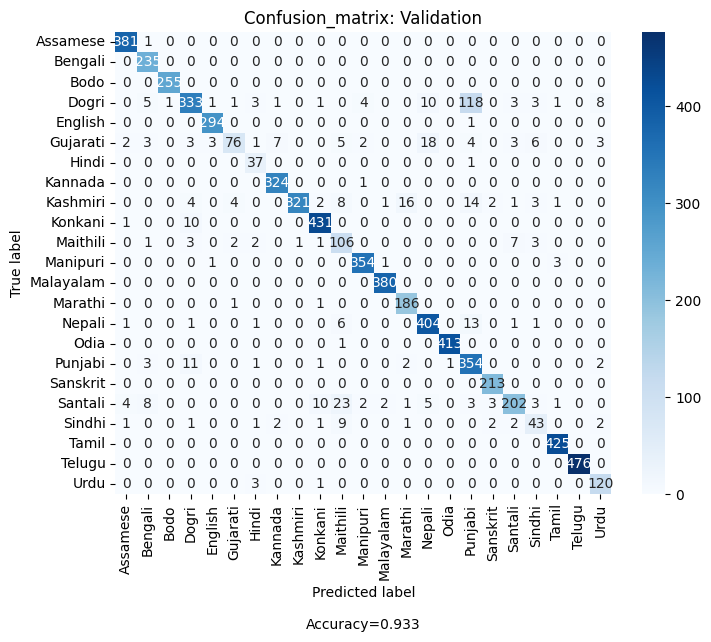

:::::Total vlidation loss 0.49333925766295916, Training accuracy 1.0, Validation accuracy 0.9332648870636551 after 14 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 15, Batch: 0, Loss: 0.0023440734948962927, Accuracy:100.0%
Epoch: 15, Batch: 50, Loss: 0.002047064248472452, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 0.09279089421033859, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 15, Batch: 50, Loss: 0.22054651379585266, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 15, Batch: 100, Loss: 0.4154008626937866, Accuracy:92.1875%


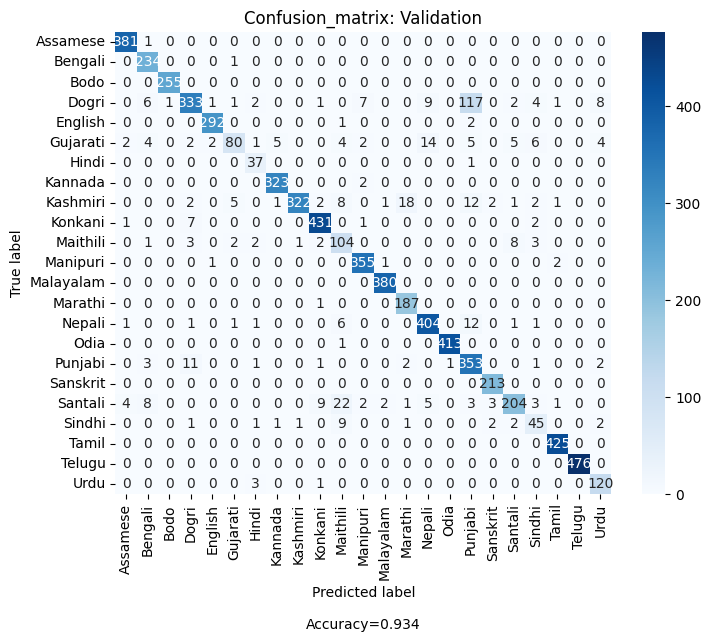

:::::Total vlidation loss 0.4963198828502236, Training accuracy 1.0, Validation accuracy 0.9338515693751833 after 15 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 16, Batch: 0, Loss: 0.0021427578758448362, Accuracy:100.0%
Epoch: 16, Batch: 50, Loss: 0.0024196275044232607, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 0.4805224537849426, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 16, Batch: 50, Loss: 0.3125923275947571, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 16, Batch: 100, Loss: 0.7089426517486572, Accuracy:92.1875%


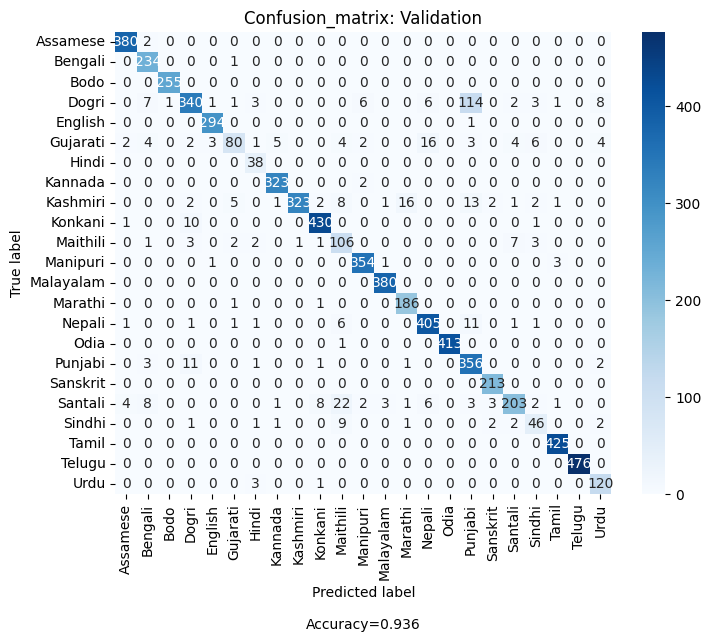

:::::Total vlidation loss 0.48071204958522745, Training accuracy 1.0, Validation accuracy 0.9357582868876504 after 16 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 17, Batch: 0, Loss: 0.0016002682968974113, Accuracy:100.0%
Epoch: 17, Batch: 50, Loss: 0.0012504681944847107, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 0.05911516025662422, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 17, Batch: 50, Loss: 0.6992900371551514, Accuracy:90.625%
#####TEST--in-domain:::::Epoch: 17, Batch: 100, Loss: 0.4109422266483307, Accuracy:95.3125%


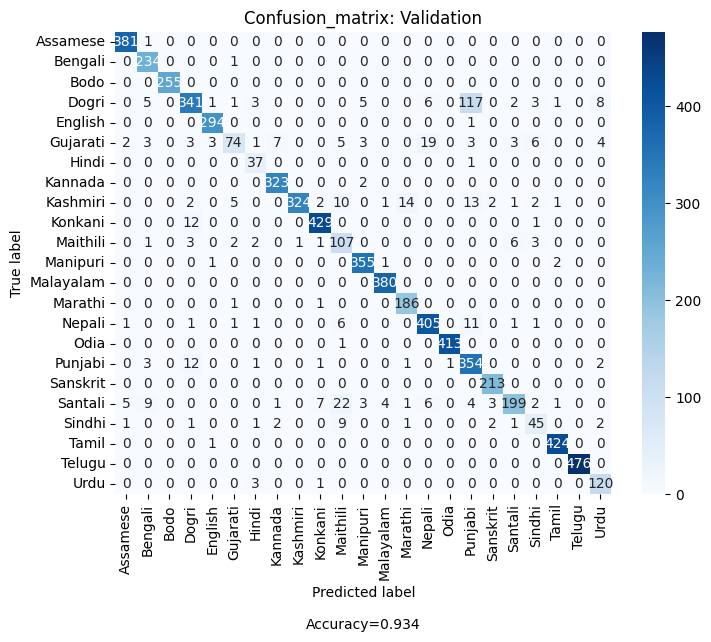

:::::Total vlidation loss 0.48055042067943055, Training accuracy 1.0, Validation accuracy 0.9341449105309475 after 17 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 18, Batch: 0, Loss: 0.0016451311530545354, Accuracy:100.0%
Epoch: 18, Batch: 50, Loss: 0.002358037047088146, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 0.4551578462123871, Accuracy:92.1875%
#####TEST--in-domain:::::Epoch: 18, Batch: 50, Loss: 0.5224173069000244, Accuracy:90.625%
#####TEST--in-domain:::::Epoch: 18, Batch: 100, Loss: 0.38524019718170166, Accuracy:96.875%


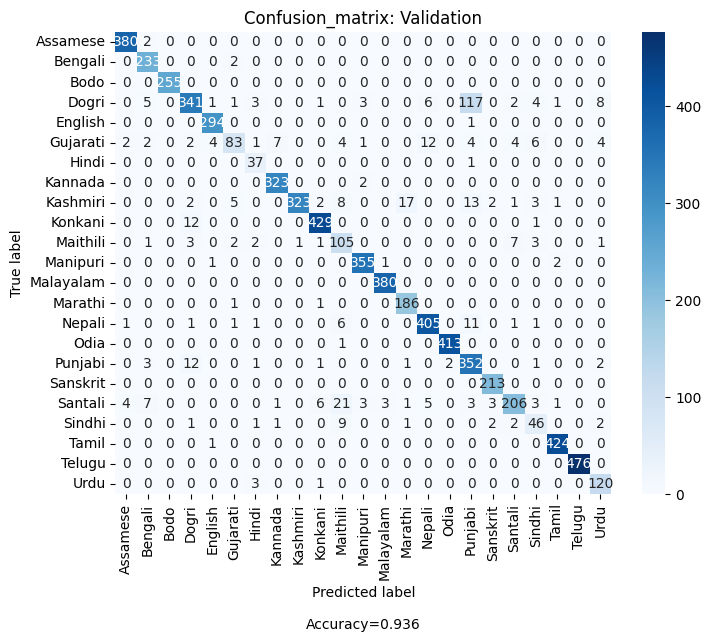

:::::Total vlidation loss 0.47042172471775073, Training accuracy 1.0, Validation accuracy 0.9356116163097683 after 18 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 19, Batch: 0, Loss: 0.006181791890412569, Accuracy:100.0%
Epoch: 19, Batch: 50, Loss: 0.002300396328791976, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 0.5695016384124756, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 19, Batch: 50, Loss: 0.6278162598609924, Accuracy:92.1875%
#####TEST--in-domain:::::Epoch: 19, Batch: 100, Loss: 0.4397689402103424, Accuracy:95.3125%


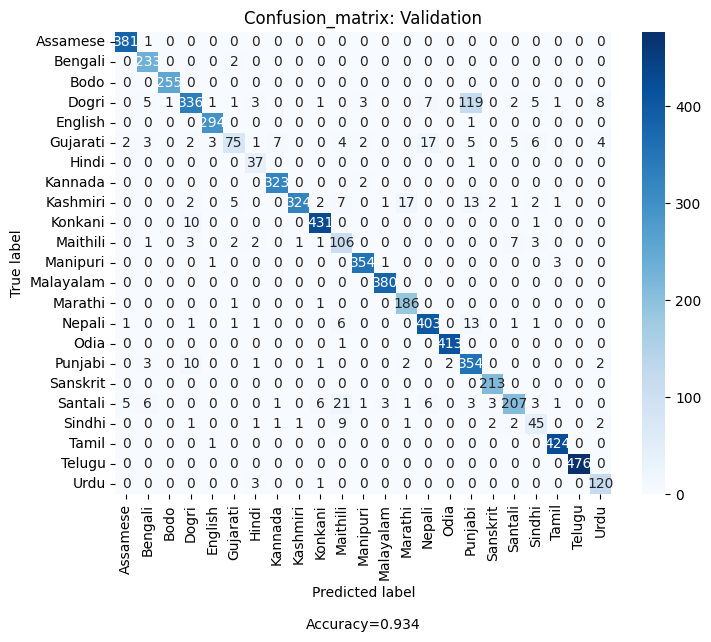

:::::Total vlidation loss 0.48723995623126554, Training accuracy 1.0, Validation accuracy 0.9342915811088296 after 19 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 20, Batch: 0, Loss: 0.0026132571510970592, Accuracy:100.0%
Epoch: 20, Batch: 50, Loss: 0.0017487998120486736, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 1.1307727098464966, Accuracy:87.5%
#####TEST--in-domain:::::Epoch: 20, Batch: 50, Loss: 0.17488320171833038, Accuracy:95.3125%
#####TEST--in-domain:::::Epoch: 20, Batch: 100, Loss: 0.5372815132141113, Accuracy:90.625%


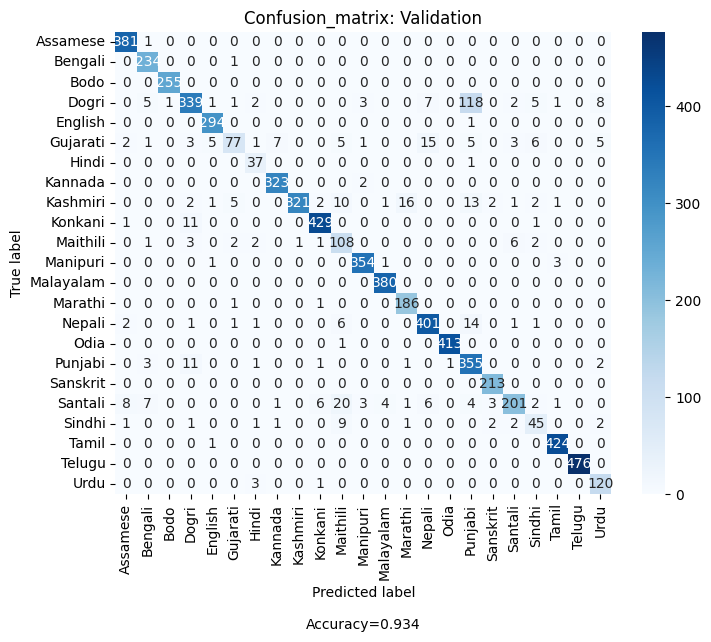

:::::Total vlidation loss 0.4921136656253834, Training accuracy 1.0, Validation accuracy 0.9337048987973012 after 20 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 21, Batch: 0, Loss: 0.002044013235718012, Accuracy:100.0%
Epoch: 21, Batch: 50, Loss: 0.00316367344930768, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 21, Batch: 0, Loss: 0.17829245328903198, Accuracy:95.3125%
#####TEST--in-domain:::::Epoch: 21, Batch: 50, Loss: 0.23753505945205688, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 21, Batch: 100, Loss: 0.7954286336898804, Accuracy:92.1875%


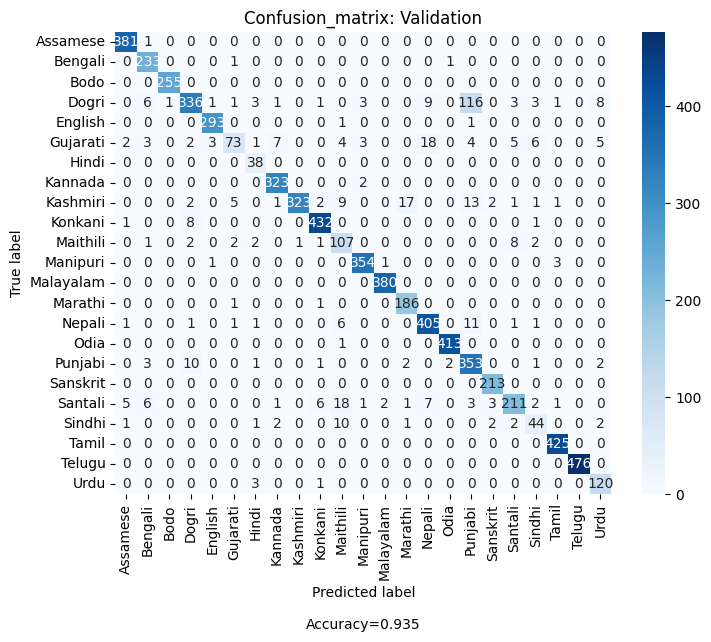

:::::Total vlidation loss 0.4879160041215821, Training accuracy 1.0, Validation accuracy 0.9348782634203578 after 21 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 22, Batch: 0, Loss: 0.002458541886880994, Accuracy:100.0%
Epoch: 22, Batch: 50, Loss: 0.0022940500639379025, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 22, Batch: 0, Loss: 0.13486243784427643, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 22, Batch: 50, Loss: 0.3958171606063843, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 22, Batch: 100, Loss: 0.6161301136016846, Accuracy:90.625%


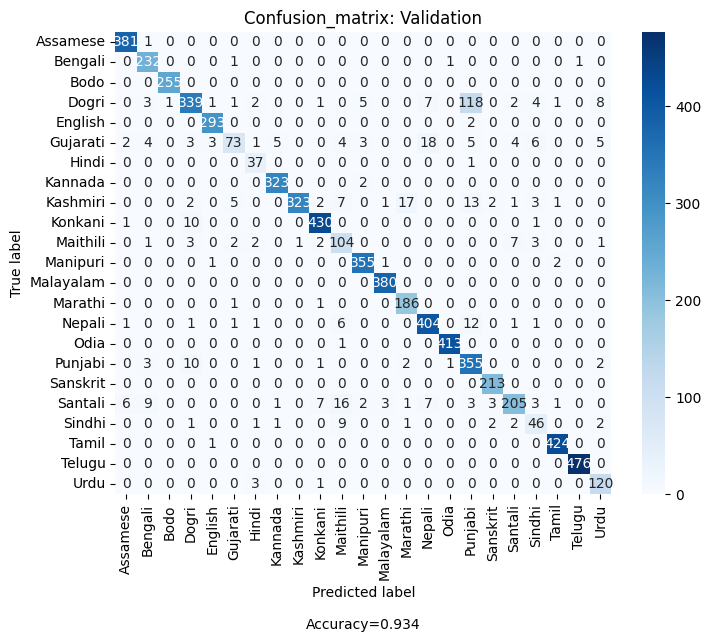

:::::Total vlidation loss 0.4913909043964416, Training accuracy 1.0, Validation accuracy 0.9338515693751833 after 22 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 23, Batch: 0, Loss: 0.0029135385993868113, Accuracy:100.0%
Epoch: 23, Batch: 50, Loss: 0.0031310217455029488, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 23, Batch: 0, Loss: 0.14480823278427124, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 23, Batch: 50, Loss: 0.2599743902683258, Accuracy:95.3125%
#####TEST--in-domain:::::Epoch: 23, Batch: 100, Loss: 0.5041736364364624, Accuracy:92.1875%


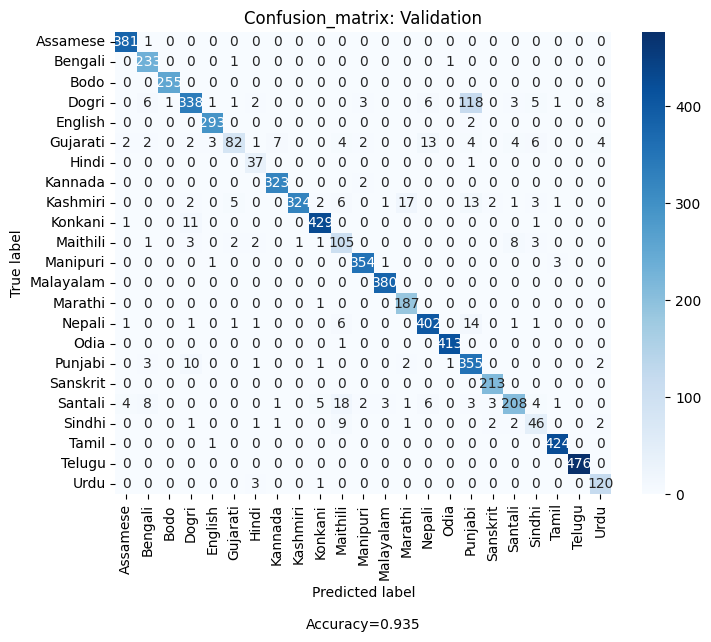

:::::Total vlidation loss 0.48135554716200457, Training accuracy 1.0, Validation accuracy 0.9354649457318862 after 23 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 24, Batch: 0, Loss: 0.004591134376823902, Accuracy:100.0%
Epoch: 24, Batch: 50, Loss: 0.003420197404921055, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 24, Batch: 0, Loss: 0.3800075650215149, Accuracy:95.3125%
#####TEST--in-domain:::::Epoch: 24, Batch: 50, Loss: 0.697513222694397, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 24, Batch: 100, Loss: 0.04242628067731857, Accuracy:98.4375%


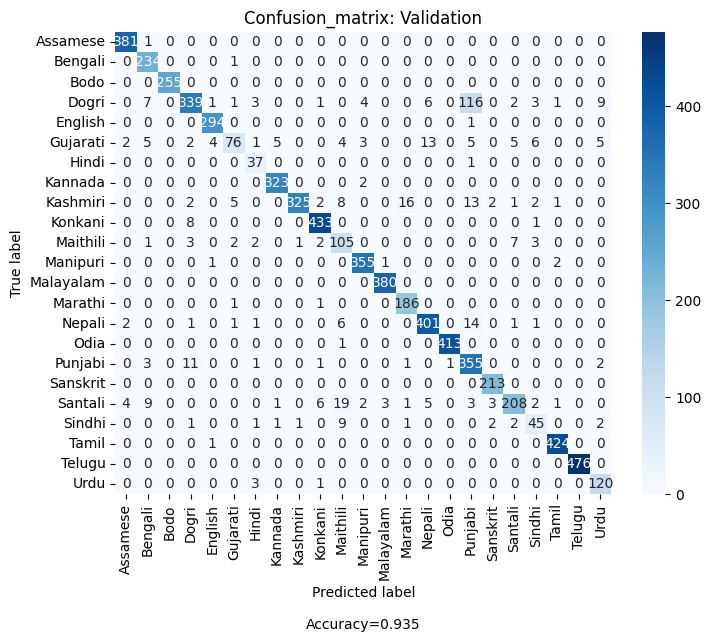

:::::Total vlidation loss 0.4851057725114243, Training accuracy 1.0, Validation accuracy 0.9354649457318862 after 24 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 25, Batch: 0, Loss: 0.002125169849023223, Accuracy:100.0%
Epoch: 25, Batch: 50, Loss: 0.0012936487328261137, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 25, Batch: 0, Loss: 0.8721931576728821, Accuracy:92.1875%
#####TEST--in-domain:::::Epoch: 25, Batch: 50, Loss: 0.7202026844024658, Accuracy:89.0625%
#####TEST--in-domain:::::Epoch: 25, Batch: 100, Loss: 0.7669080495834351, Accuracy:89.0625%


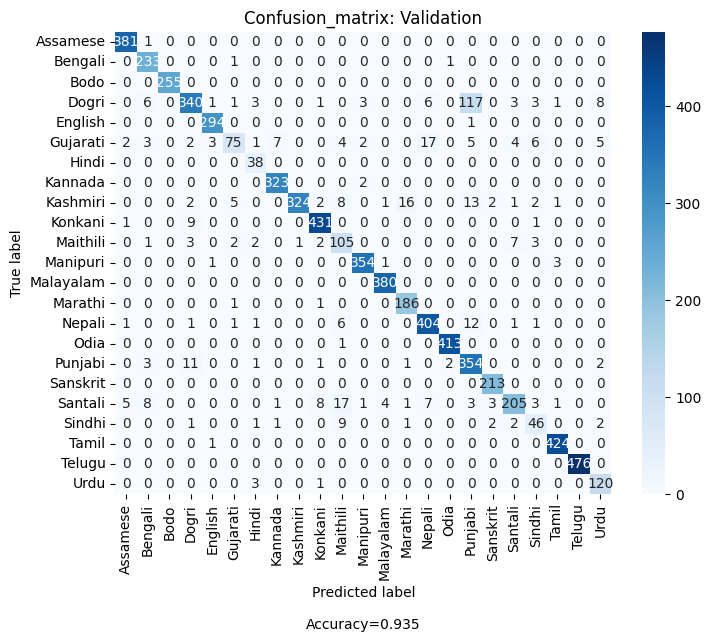

:::::Total vlidation loss 0.48823183035982826, Training accuracy 1.0, Validation accuracy 0.9348782634203578 after 25 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 26, Batch: 0, Loss: 0.003689969191327691, Accuracy:100.0%


KeyboardInterrupt: 

In [16]:
#For LR scheduler
import warnings
warnings.filterwarnings('ignore')
dest_path="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/"
os.makedirs(dest_path,exist_ok=True)
Languages=["Assamese","Bengali","Bodo","Dogri","English","Gujarati","Hindi","Kannada","Kashmiri","Konkani","Maithili","Manipuri","Malayalam","Marathi","Nepali","Odia","Punjabi","Sanskrit","Santali","Sindhi","Tamil","Telugu","Urdu"]
#Languages=["Bengali","Hindi","Punjabi","Tamil","Urdu"]
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix
def train(dataloader_train,epoch):
    train_loss_list=[]
    train_acc_list=[]
    full_preds=[]
    full_gts=[]

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data
        #features=torch.transpose(features,0,2,1)
        #print(features.shape)
        #print(labels.shape)
        #features=minmax(features)
        features, labels = features.to(device).float(),labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits = model(features)
        loss=model.get_loss(pred_logits,labels)
        posterior=model.get_posterior()
        #print(posterior.shape)
        #loss = loss_fun(pred_logits,labels)

        #print(pred_logits.shape)
        #LOSS=[]
        #for ii in range(features.shape[1]):
        #    loss = loss_fun(features[:,ii,:],labels)
        #    LOSS.append(loss)
        #loss=torch.mean(torch.tensor(LOSS))
        #loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
        if i_batch%50==0:
            #print(final_pred)
            acc = accuracy_score(predictions,labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
        train_loss_list.append(loss.item())
        for pred in predictions:
            full_preds.append(pred)
        for lab in labels.detach().cpu().numpy():
            full_gts.append(lab)
    mean_acc = accuracy_score(full_gts,full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    return mean_acc
    print('Total training loss {} and training Accuracy {} after {} epochs'.format(mean_loss,mean_acc,epoch))
def validation(dataloader_val,epoch,train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list=[]
        full_preds=[]
        full_gts=[]
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            #features=torch.transpose(features,0,2,1)
            features, labels = features.to(device).float(),labels.to(device).long()
            pred_logits = model(features)
            #print(features.shape)
            #print(labels.shape)
            loss=model.get_loss(pred_logits,labels)
            posterior=model.get_posterior()
            #loss = loss_fun(pred_logits,labels)
            val_loss_list.append(loss.item())
            predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
            if i_batch%50==0:
                #print(final_pred)
                acc = accuracy_score(predictions,labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)

        mean_acc2 = accuracy_score(full_gts,full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm=confusion_matrix(full_gts,full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8,6), categories=Languages, cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(':::::Total vlidation loss {}, Training accuracy {}, Validation accuracy {} after {} epochs'.format(mean_loss2,train_accuracy, mean_acc2,epoch))
        print("#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############")
        model_save_path = os.path.join(dest_path,'wav2vec2_23lang_IIITH_Bhagya_ecapa_cms_'+str("{:.3f}".format(train_accuracy*100))+"_"+str("{:.3f}".format(mean_acc2*100))+"_"+str("{:.4f}".format(mean_loss2)))
        state_dict = {'model': model.state_dict(),'optimizer': optimizer.state_dict(),'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return loss

if __name__ == '__main__':
    for epoch in range(50):
        mean_acc=train(trainloader,epoch)
        val_loss=validation(testloader1,epoch,mean_acc)
        scheduler.step(val_loss)
        #testing(testloader2,epoch,mean_acc)
        #testing(testloader3,epoch,mean_acc)